# Predict TCR and peptide-HLA binding

**T cell receptors (TCR)**, expressed on the surface of T cells, recognize and bind to immunogenic peptides or epitopes presented by human leukocyte antigen (HLA). This recognition process is fundamental to the adaptive immune system and serves as a critical mechanism for identifying and responding to pathogenic threats.  A diverse array of TCRs ensures protection against a wide range of pathogens and malignant cells. Mechanisms exist to eliminate T cells that recognize self-antigens (central and peripheral tolerance), but self-tolerance can fail, leading to **autoimmunity**, especially when hidden self-antigens are exposed or when microbial antigens mimic self-antigens. **Identifying the specific epitopes that trigger T cell activation in different disease contexts** can provide crucial insights into disease pathogenesis and could enable the development of personalized therapies, such as **tolerance-inducing vaccines** or **TCR-specific T cell depletion**. 

```{image} ../_static/TCR.png
:alt: 模型结果图
:width: 600px
:align: center

There are **5 million unique TCRs** per individual, and the TCR repertoire is highly diverse. The TCR repertoire is shaped by the individual's genetics, environmental exposures, and immune history. This diversity allows the immune system to recognize a wide range of antigens, but it also makes it challenging to predict which TCRs will bind to specific peptides or HLA molecules.

Here we use public dataset from [VDJdb](https://vdjdb.cdr3.net/) to train a model to predict TCR-peptide-HLA binding. The dataset contains TCR sequences, peptide sequences, and HLA alleles associated with T cell responses. We will use this data to train a machine learning model that can predict whether a given TCR will bind to a specific peptide-HLA complex.

## Load TCR and peptide-HLA binding data. 

Load our training data ([Download here](https://drive.google.com/file/d/1Wi1p9AeybGPzCj391hO5e0_bnl_Z2pAW/view?usp=drive_link))
1. TCRs with alpha and beta chain, V and J gene information 
2. Peptide and HLA information

In [1]:
import pandas as pd
from themap import utils
from themap.model import THE, PEP_vae
import torch
import numpy as np

import warnings
warnings.filterwarnings("ignore")

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train = pd.read_csv('VDJdb_train.csv')

### Reconstruct full TCR sequences by CDR3 and VJ gene information

The TCR sequences in the dataset are often represented by their CDR3 regions, which are the most variable and antigen-specific parts of the TCR. To reconstruct the full TCR sequences, we need to combine the CDR3 regions with their corresponding V and J gene segments. This process involves using the V and J gene information to identify the appropriate gene segments and then concatenating them with the CDR3 regions to form the complete TCR sequences.

If you want to use your own TCR sequences, please make sure they are in the same format as the dataset. The TCR sequences should be in the form of CDR3 regions, and the V and J gene information should be provided separately. **All V and J genes should be in the Allele column of the trajs_aa.tsv, trajs_aa.tsv, trbjs_aa.tsv, and trbjs_aa.tsv.** in the 'library/' folder.

Or you can train the model using only CDR3 regions, but the performance may be lower.

In [2]:
df_train['alpha'] = utils.determine_tcr_seq_vj(df_train['alpha'].tolist(), df_train['V_alpha'].tolist(), df_train['J_alpha'].tolist(), chain='A')
df_train['beta'] = utils.determine_tcr_seq_vj(df_train['beta'].tolist(), df_train['V_beta'].tolist(), df_train['J_beta'].tolist(), chain='B')
df_train = df_train[['alpha', 'beta', 'V_alpha', 'J_alpha', 'V_beta', 'J_beta', 'HLA', 'Epitope']]
print(df_train.iloc[0])

alpha      AQKITQTQPGMFVQEKEAVTLDCTYDTSDPSYGLFWYKQPSSGEMI...
beta       DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFL...
V_alpha                                        TRAV14/DV4*01
J_alpha                                            TRAJ12*01
V_beta                                              TRBV9*01
J_beta                                            TRBJ1-2*01
HLA                                                 HLA-A*03
Epitope                                            KLGGALQAK
Name: 0, dtype: object


Show TCR distribution for top 15 epitopes in the dataset. It is domianted by the 'KLGGALQAK' epitopes.

<Axes: xlabel='Epitope'>

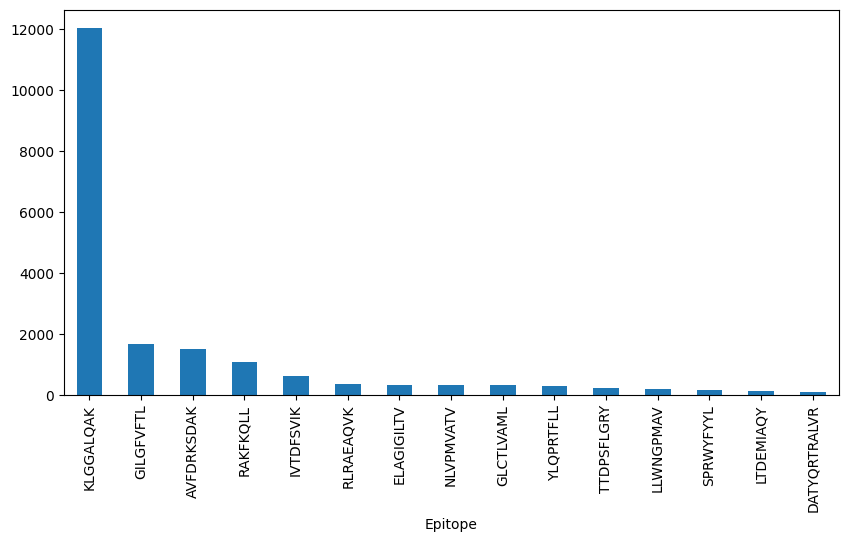

In [3]:
df_train['Epitope'].value_counts()[0:15].plot(kind='bar', figsize=(10, 5))

## Train and save the model

In [4]:
THEmodel = THE().to(device)
THEmodel.train_model(df_train, num_epochs=20, device=device)
torch.save(THEmodel.state_dict(), 'THE_model.pt')


████████╗██╗░░██╗███████╗███╗░░░███╗░█████╗░██████╗░
╚══██╔══╝██║░░██║██╔════╝████╗░████║██╔══██╗██╔══██╗
░░░██║░░░███████║█████╗░░██╔████╔██║███████║██████╔╝
░░░██║░░░██╔══██║██╔══╝░░██║╚██╔╝██║██╔══██║██╔═══╝░
░░░██║░░░██║░░██║███████╗██║░╚═╝░██║██║░░██║██║░░░░░
░░░╚═╝░░░╚═╝░░╚═╝╚══════╝╚═╝░░░░░╚═╝╚═╝░░╚═╝╚═╝░░░░░
        


INFO:themap.model:Training...
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:themap.model:Loading alpha_dict.pt
INFO:themap.model:No new CDR3alpha sequences found
INFO:themap.model:Loading beta_dict.pt
INFO:themap.model:No new CDR3beta sequences found
100%|██████████| 253/253 [01:07<00:00,  3.74it/s]


Epoch [1/20], Loss: 0.6152, ROC: 0.6933


100%|██████████| 252/252 [00:59<00:00,  4.26it/s]


Epoch [2/20], Loss: 0.5394, ROC: 0.7498


100%|██████████| 253/253 [01:18<00:00,  3.24it/s]


Epoch [3/20], Loss: 0.5514, ROC: 0.7743


100%|██████████| 253/253 [01:02<00:00,  4.04it/s]


Epoch [4/20], Loss: 0.5835, ROC: 0.7902


100%|██████████| 253/253 [01:04<00:00,  3.91it/s]


Epoch [5/20], Loss: 0.3517, ROC: 0.8045


100%|██████████| 252/252 [01:07<00:00,  3.72it/s]


Epoch [6/20], Loss: 0.4643, ROC: 0.8171


100%|██████████| 253/253 [00:54<00:00,  4.62it/s]


Epoch [7/20], Loss: 0.3954, ROC: 0.8281


100%|██████████| 252/252 [00:54<00:00,  4.61it/s]


Epoch [8/20], Loss: 0.5236, ROC: 0.8372


100%|██████████| 253/253 [00:55<00:00,  4.54it/s]


Epoch [9/20], Loss: 0.5375, ROC: 0.8472


100%|██████████| 253/253 [00:55<00:00,  4.58it/s]


Epoch [10/20], Loss: 0.4031, ROC: 0.8572


100%|██████████| 253/253 [00:53<00:00,  4.73it/s]


Epoch [11/20], Loss: 0.4266, ROC: 0.8634


100%|██████████| 253/253 [00:55<00:00,  4.54it/s]


Epoch [12/20], Loss: 0.2511, ROC: 0.8746


100%|██████████| 253/253 [01:00<00:00,  4.16it/s]


Epoch [13/20], Loss: 0.5195, ROC: 0.8829


100%|██████████| 252/252 [00:54<00:00,  4.64it/s]


Epoch [14/20], Loss: 0.4364, ROC: 0.8927


100%|██████████| 253/253 [00:55<00:00,  4.55it/s]


Epoch [15/20], Loss: 0.5727, ROC: 0.9016


100%|██████████| 252/252 [01:07<00:00,  3.72it/s]


Epoch [16/20], Loss: 0.3470, ROC: 0.9093


100%|██████████| 252/252 [01:11<00:00,  3.55it/s]


Epoch [17/20], Loss: 0.3069, ROC: 0.9173


100%|██████████| 253/253 [00:57<00:00,  4.43it/s]


Epoch [18/20], Loss: 0.4123, ROC: 0.9254


100%|██████████| 252/252 [00:54<00:00,  4.61it/s]


Epoch [19/20], Loss: 0.3053, ROC: 0.9314


100%|██████████| 252/252 [00:54<00:00,  4.65it/s]


Epoch [20/20], Loss: 0.2523, ROC: 0.9383


### (optional) Load pretrained model
If you want to use a pretrained model, you can download it from [here](https://drive.google.com/file/d/1liKCdCACvxinCogHL4rqTyxP_i0CKk2O/view?usp=drive_link) and load it using the following code:


In [4]:
THEmodel = THE().to(device)
THEmodel.load_state_dict(torch.load('THE_model.pt', map_location=device))

<All keys matched successfully>

## Test the model

Load the test data ([Download here](https://drive.google.com/file/d/1e4xRJwwyhQGzHcx-k5MynKuv52Y0DqAw/view?usp=drive_link))

In [6]:
df_test = pd.read_csv('VDJdb_test.csv')
df_test['alpha'] = utils.determine_tcr_seq_vj(df_test['alpha'].tolist(), df_test['V_alpha'].tolist(), df_test['J_alpha'].tolist(), chain='A')
df_test['beta'] = utils.determine_tcr_seq_vj(df_test['beta'].tolist(), df_test['V_beta'].tolist(), df_test['J_beta'].tolist(), chain='B')
result, cdr3a_attn, cdr3b_attn = THEmodel.test_model(df_test=df_test, device=device)
df_test['pred'] = result

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:themap.model:Loading alpha_dict.pt
INFO:themap.model:No new CDR3alpha sequences found
INFO:themap.model:Loading beta_dict.pt
INFO:themap.model:No new CDR3beta sequences found
INFO:themap.model:Predicting...
100%|██████████| 44/44 [00:13<00:00,  3.16it/s]


Plot AUC and PR curves for the model.

THE: ROC-AUC: 0.8565
THE: PRC-AUC: 0.4687


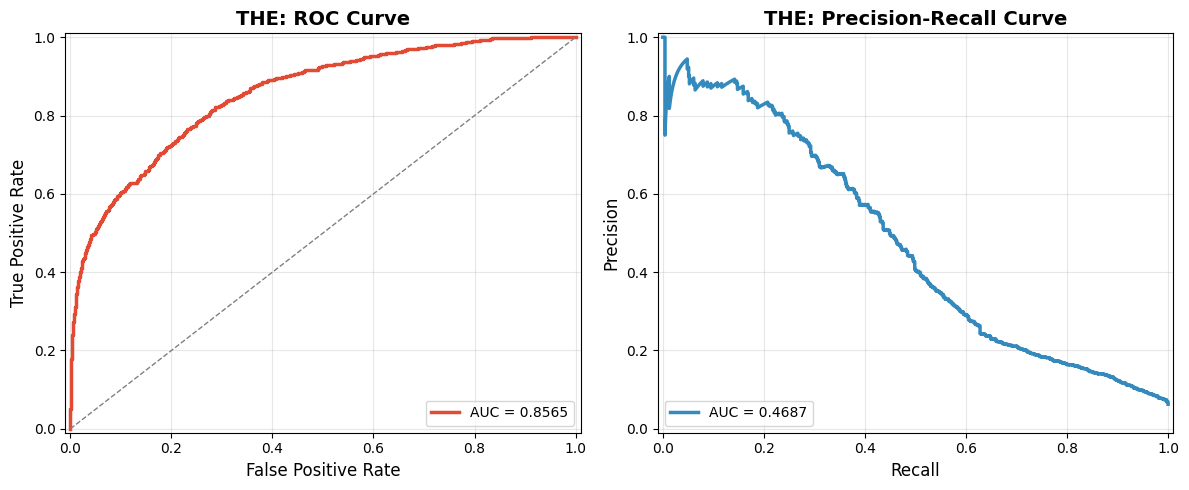

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score
)

def plot_roc_prc_curve(y_true, y_scores, title_prefix=''):
    """
    Plot aesthetically improved ROC and Precision-Recall curves with AUC scores.

    Args:
        y_true (array-like): Ground truth binary labels (0 or 1).
        y_scores (array-like): Predicted scores (e.g., probabilities).
        title_prefix (str): Optional prefix for plot titles.
    """
    # Use a clean style
    plt.style.use('seaborn-v0_8-muted')

    # Compute metrics
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = average_precision_score(y_true, y_scores)

    # Print AUC values
    print(f'{title_prefix}ROC-AUC: {roc_auc:.4f}')
    print(f'{title_prefix}PRC-AUC: {prc_auc:.4f}')

    # Set up plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='#E24A33', lw=2.5, label=f'AUC = {roc_auc:.4f}')
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    axes[0].set_xlim([-0.01, 1.01])
    axes[0].set_ylim([-0.01, 1.01])
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title(f'{title_prefix}ROC Curve', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(alpha=0.3)

    # PRC Curve
    axes[1].plot(recall, precision, color='#348ABD', lw=2.5, label=f'AUC = {prc_auc:.4f}')
    axes[1].set_xlim([-0.01, 1.01])
    axes[1].set_ylim([-0.01, 1.01])
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title(f'{title_prefix}Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot ROC and Precision-Recall curves
plot_roc_prc_curve(df_test['label'], df_test['pred'], title_prefix='THE: ')

## Mean predictive score of ture postive and false postive pairs for each peptide

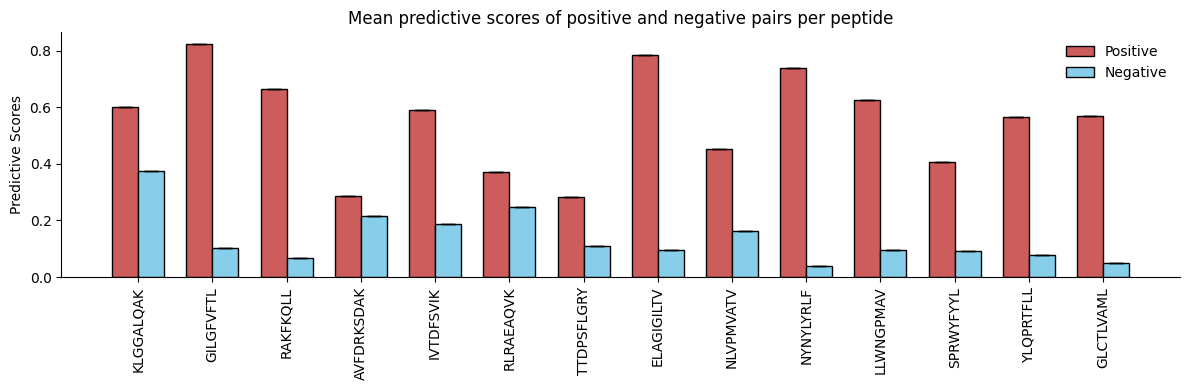

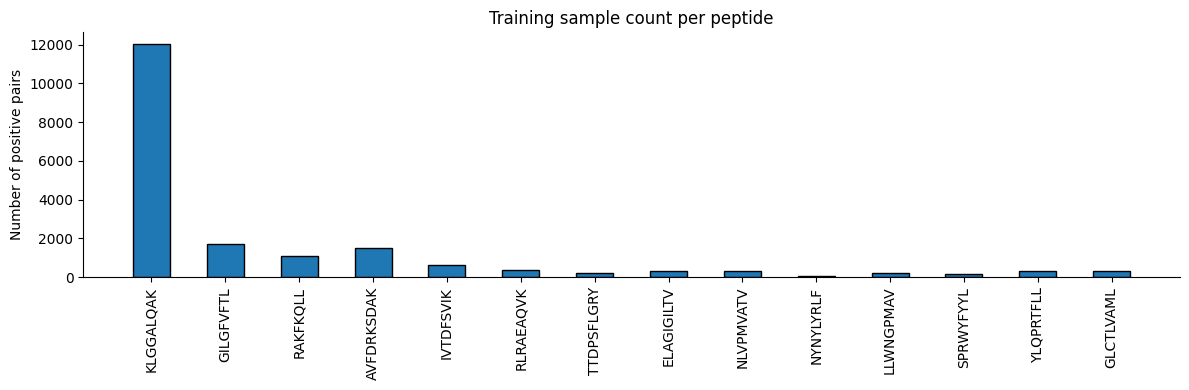

In [9]:
def compute_score_stats(df_list, top_epitopes):
    tp_all, fp_all = [], []
    for df in df_list:
        tp, fp = [], []
        for pep in top_epitopes:
            preds = df[df['Epitope'] == pep]
            tp.append(np.mean(preds[preds['label'] == 1]['pred']))
            fp.append(np.mean(preds[preds['label'] == 0]['pred']))
        tp_all.append(tp)
        fp_all.append(fp)
    tp_arr = np.array(tp_all)
    fp_arr = np.array(fp_all)
    return (
        np.nanmean(tp_arr, axis=0), np.nanstd(tp_arr, axis=0),
        np.nanmean(fp_arr, axis=0), np.nanstd(fp_arr, axis=0)
    )

def plot_score_bars(top_epitopes, tp_mean, tp_std, fp_mean, fp_std):
    x = np.arange(len(top_epitopes))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(x - width/2, tp_mean, width, yerr=tp_std, label='Positive', color='indianred', capsize=5, edgecolor='black')
    ax.bar(x + width/2, fp_mean, width, yerr=fp_std, label='Negative', color='skyblue', capsize=5, edgecolor='black')
    ax.set_ylabel('Predictive Scores')
    ax.set_title('Mean predictive scores of positive and negative pairs per peptide')
    ax.set_xticks(x)
    ax.set_xticklabels(top_epitopes, rotation='vertical')
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()

def plot_peptide_counts(df_train, top_epitopes):
    counts = [df_train[df_train['Epitope'] == pep].shape[0] for pep in top_epitopes]
    x = np.arange(len(top_epitopes))
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(x, counts, width=0.5, color='#1f77b4', edgecolor='black')
    ax.set_ylabel('Number of positive pairs')
    ax.set_title('Training sample count per peptide')
    ax.set_xticks(x)
    ax.set_xticklabels(top_epitopes, rotation='vertical')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()

# Prepare data
top_epitopes = df_test['Epitope'].value_counts().head(15).index.tolist()

# Simulate multiple folds
df_test_list = [df_test.copy() for _ in range(1, 10)]  # assume 9 test folds

# Compute mean and std of predictive scores
tp_mean, tp_std, fp_mean, fp_std = compute_score_stats(df_test_list, top_epitopes)

# Plot predictive scores
plot_score_bars(top_epitopes, tp_mean, tp_std, fp_mean, fp_std)

# Plot training sample counts
plot_peptide_counts(df_train, top_epitopes)

plt.show()

## Plot the precision for each peptide across different thresholds
This evaluates whether the model’s high-confidence predictions are indeed true positives.

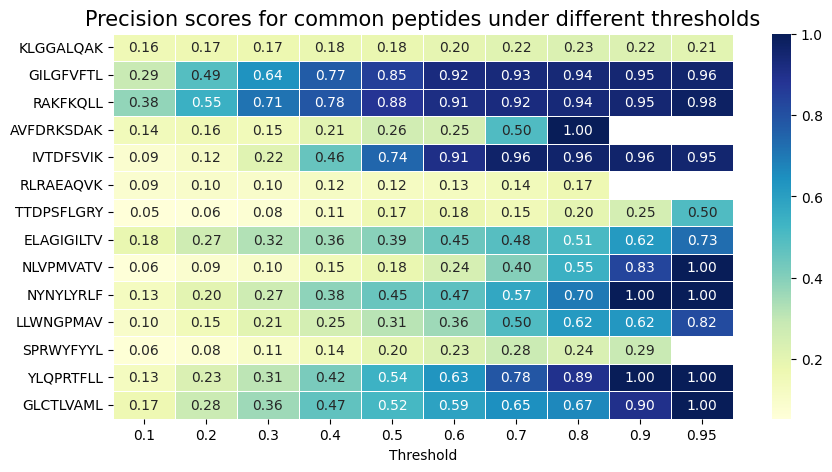

In [10]:
# if precision is -1, it means there is no positive prediction
import seaborn as sns
from sklearn.metrics import confusion_matrix

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
precision_all = []
for pep in top_epitopes:
    precision_list = [] 
    for threshold in thresholds:
        df_baselines = df_test[df_test['Epitope'] == pep]
        cm = confusion_matrix(df_baselines['label'].values, df_baselines['pred'].values > threshold)
        TP = cm[1, 1]
        FP = cm[0, 1]
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0 
        precision_list.append(precision)
    precision_all.append(precision_list)


# Create a DataFrame
df = pd.DataFrame(precision_all, columns=thresholds, index=top_epitopes)

# Create the heatmap
# if precision is 0, delete the value
df = df.replace(0, np.nan)
plt.figure(figsize=(10, 5))
sns.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Threshold')
plt.title('Precision scores for common peptides under different thresholds', fontsize=15)
plt.show()